In [6]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from copy import *
from sklearn.metrics import root_mean_squared_error

from surprise import SVD, NMF
from surprise import Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.reader import Reader
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", index_col=0)

min_reviews = 10 # change to set one
rev_filter = filter_df(avis_clean, min_reviews)

# create user-game matrix
#user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
SPLITS=5

11201 10549
2086 2464
1800 2399
1792 2397
1791 2396


### Perform cross-validation to choose `n_components`

In [3]:
# ranks = np.arange(5, 70, step=5)
# results = []
# SPLITS = 5
# for rank in ranks:
#     nmf = NMF(n_factors=rank, random_state=1)
#     results.append(cross_validate(nmf, data, measures=["RMSE", "MAE"], cv=SPLITS, verbose=True))

Add data for `DataFrame` generation

In [4]:
# res_copy = deepcopy(results)
# for d, k in zip(res_copy, ranks):
#     d['k'] = [k] * SPLITS
#     d["mean_rmse"] = np.mean(d["test_rmse"])
#     d["mean_mae"] = np.mean(d["test_mae"])

Create / load `DataFrame` to plot

In [ ]:
# rmse = np.array([d["test_rmse"] for d in results])
# mae = np.array([d["test_mae"] for d in results])

# df=pd.json_normalize(res_copy) 
# df = df.apply(lambda x: x.explode()).reset_index(drop=True)
df = pd.read_csv("generated_data/NNMF_rmse_mae.csv", index_col=0)
# df_means = df[["mean_rmse", "mean_mae", "k"]].drop_duplicates()

### Plot RMSE

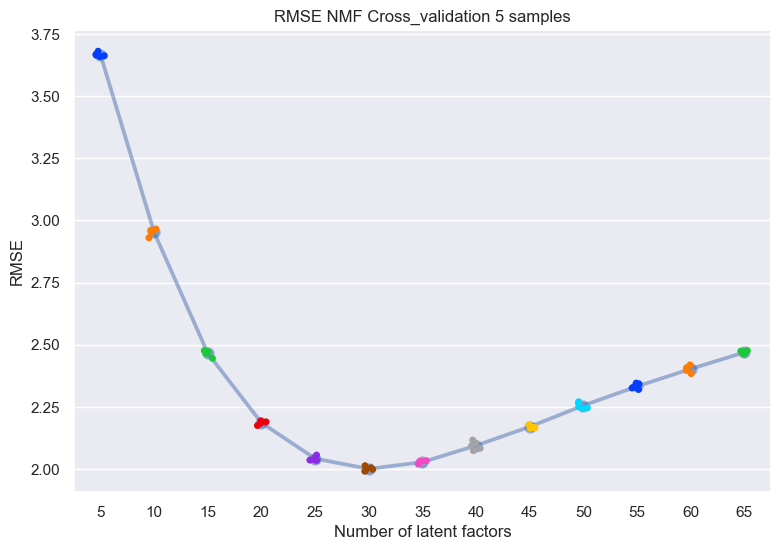

In [24]:
sns.set_theme(rc={'figure.figsize':(9,6)})
#ax = sns.boxplot(data=df, x="k", y="test_rmse", width=.5, whis=(0, 100))
ax = sns.stripplot(data=df, x="k", y="test_rmse", hue="k", palette="bright")
sns.pointplot(data=df, x="k", y="mean_rmse", alpha=0.5)
ax.set_title(f"RMSE NMF Cross_validation {SPLITS} samples")
ax.set_xlabel("Number of latent factors")
ax.set_ylabel("RMSE")
plt.legend([],[], frameon=False)

### Plot MAE

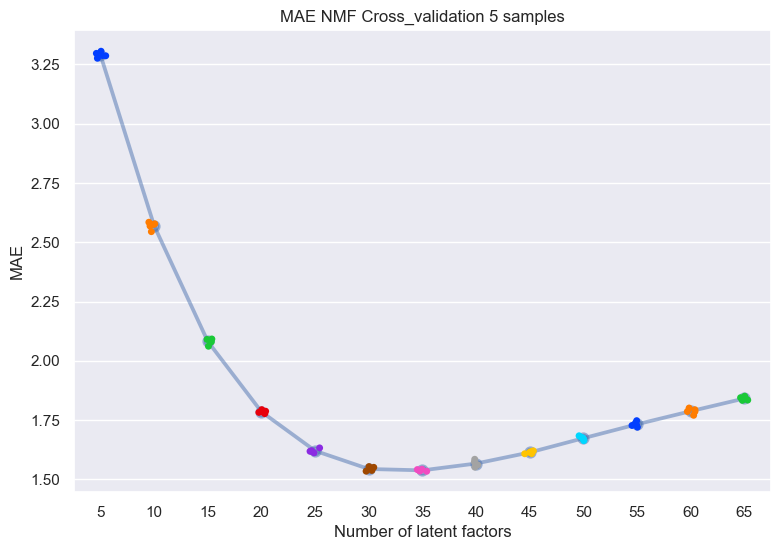

In [23]:
sns.set_theme(rc={'figure.figsize':(9,6)})
#ax = sns.boxplot(data=df, x="k", y="test_rmse", width=.5, whis=(0, 100))
ax = sns.stripplot(data=df, x="k", y="test_mae", hue="k", palette="bright")
sns.pointplot(data=df, x="k", y="mean_mae", alpha=0.5)
ax.set_title(f"MAE NMF Cross_validation {SPLITS} samples")
ax.set_xlabel("Number of latent factors")
ax.set_ylabel("MAE")
plt.legend([],[], frameon=False)

### Plot $H$, $W$ matrices for $30$ components (best rmse, mae)

In [18]:
trainset = data.build_full_trainset()
#trainset, testest = train_test_split(data, test_size=0.2)


# Train NMF model
nmf = NMF(n_factors=30, random_state=1)
nmf.fit(trainset)

# Extract matrices
W = nmf.pu  # User-feature matrix (W)
H = nmf.qi  # Item-feature matrix (H)

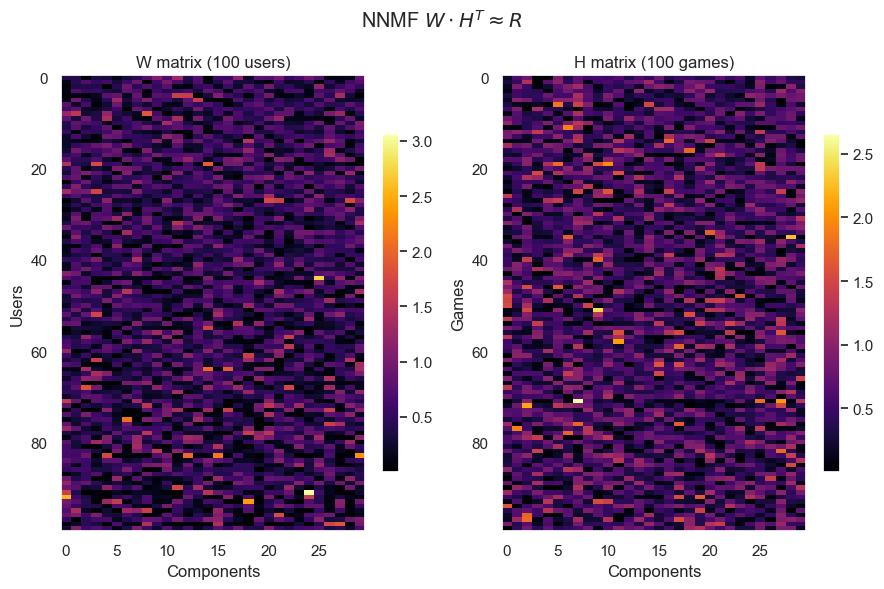

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)

Wim = ax1.imshow(W[:100, :], aspect='auto', cmap="inferno")
ax1.set_xlabel("Components")
ax1.set_ylabel("Users")
ax1.set_title("W matrix (100 users)")
ax1.grid(False)

Him = ax2.imshow(H[:100, :], aspect='auto', cmap="inferno")
ax2.set_xlabel("Components")
ax2.set_ylabel("Games")
ax2.set_title("H matrix (100 games)")
ax2.grid(False)

fig.colorbar(Him, fraction=0.05)
fig.colorbar(Wim, fraction=0.05)

fig.suptitle(r"NNMF $W \cdot H^T \approx R$")
fig.set_size_inches(9, 6)
plt.tight_layout()